In [ ]:
!pip install opencv-python-headless scikit-image tqdm scikit-learn matplotlib

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import io
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
real_path = '/content/drive/MyDrive/deepfake/real_'
fake_path = '/content/drive/MyDrive/deepfake/ai_'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preprocessed image save paths
preproc_real_path = '/content/drive/MyDrive/deepfake/preprocessed/real/'
preproc_fake_path = '/content/drive/MyDrive/deepfake/preprocessed/ai/'

os.makedirs(preproc_real_path, exist_ok=True)
os.makedirs(preproc_fake_path, exist_ok=True)
def preprocess_and_save(src_folder, dst_folder):
    for filename in tqdm(os.listdir(src_folder)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(os.path.join(src_folder, filename), cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (512, 512))
            save_path = os.path.join(dst_folder, filename)
            cv2.imwrite(save_path, img_resized)

# Apply for both real and fake images
preprocess_and_save(real_path, preproc_real_path)
preprocess_and_save(fake_path, preproc_fake_path)

100%|██████████| 1700/1700 [00:58<00:00, 28.95it/s]


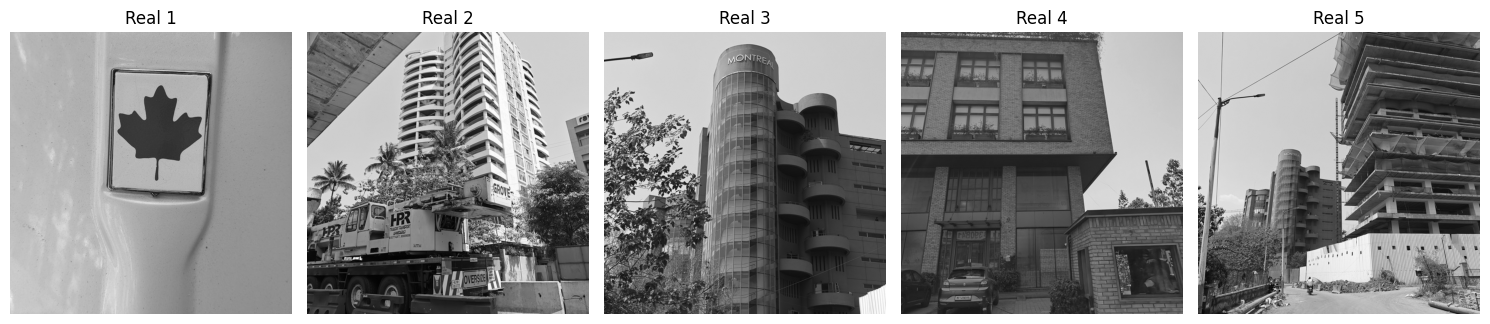

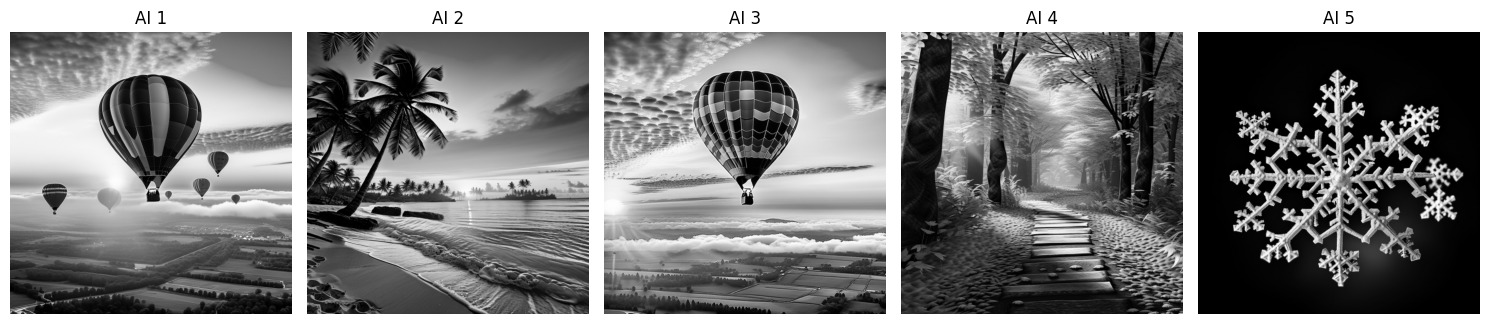

In [ ]:
def show_sample_images(folder, title, n=5):
    images = os.listdir(folder)[:n]
    plt.figure(figsize=(15, 5))
    for i, fname in enumerate(images):
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(preproc_real_path, "Real")
show_sample_images(preproc_fake_path, "AI")


In [ ]:
laplacian_real_path = '/content/drive/MyDrive/deepfake/residuals/real/'
laplacian_fake_path = '/content/drive/MyDrive/deepfake/residuals/ai/'

os.makedirs(laplacian_real_path, exist_ok=True)
os.makedirs(laplacian_fake_path, exist_ok=True)

def laplacian_residual(image):
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])
    return cv2.filter2D(image.astype(np.float32), -1, kernel)

def extract_and_save_residuals(input_folder, output_folder):
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE)
            residual = laplacian_residual(img)
            residual_path = os.path.join(output_folder, filename.replace('.jpg', '.npy').replace('.png', '.npy'))
            np.save(residual_path, residual)

extract_and_save_residuals(preproc_real_path, laplacian_real_path)
extract_and_save_residuals(preproc_fake_path, laplacian_fake_path)


100%|██████████| 1700/1700 [01:02<00:00, 27.10it/s]


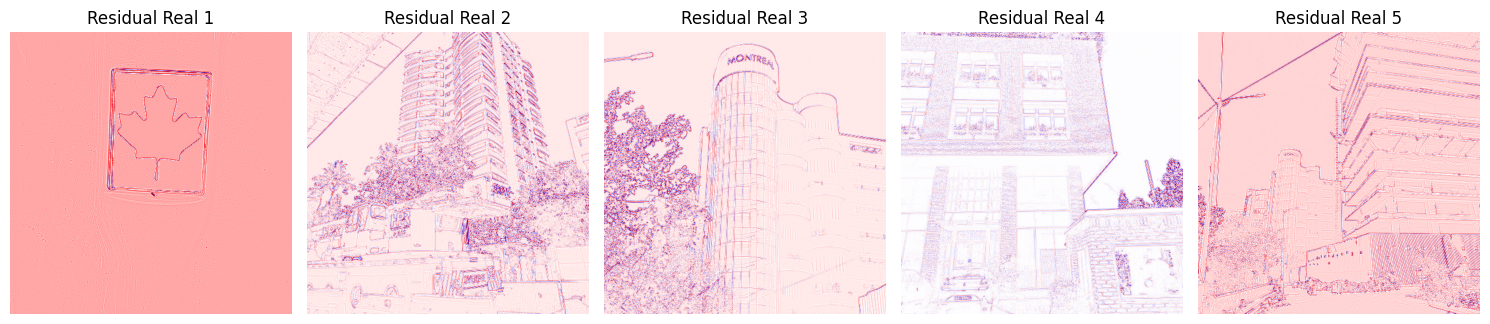

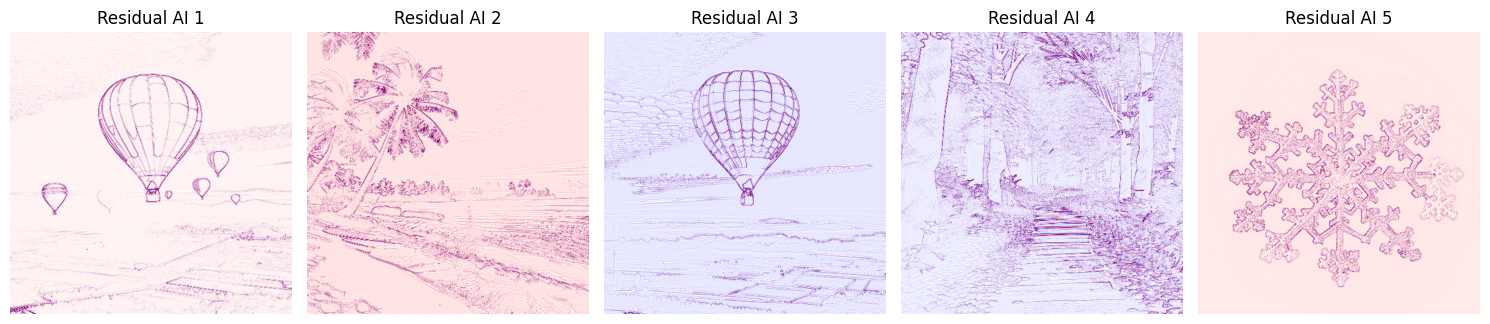

In [ ]:
def show_sample_residuals(folder, title, n=5):
    files = os.listdir(folder)[:n]
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        res = np.load(os.path.join(folder, file))
        plt.subplot(1, n, i + 1)
        plt.imshow(res, cmap='seismic')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_residuals(laplacian_real_path, "Residual Real")
show_sample_residuals(laplacian_fake_path, "Residual AI")


In [ ]:
def box_count(Z, threshold=0.01):
    Z = np.abs(Z)
    sizes = np.logspace(2, 7, num=6, base=2, dtype=int)  # box sizes
    counts = []
    for size in sizes:
        S = cv2.resize(Z, (size, size), interpolation=cv2.INTER_NEAREST)
        count = np.sum(S > threshold)
        counts.append(count)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]  # FD


In [ ]:
fd_real_path = '/content/drive/MyDrive/deepfake/features/fd_real.npy'
fd_fake_path = '/content/drive/MyDrive/deepfake/features/fd_fake.npy'

def compute_fd_features(folder):
    features = []
    for file in tqdm(os.listdir(folder)):
        if file.endswith('.npy'):
            res = np.load(os.path.join(folder, file))
            fd = box_count(res)
            features.append(fd)
    return np.array(features)

os.makedirs(os.path.dirname(fd_real_path), exist_ok=True)

fd_real = compute_fd_features(laplacian_real_path)
fd_fake = compute_fd_features(laplacian_fake_path)

np.save(fd_real_path, fd_real)
np.save(fd_fake_path, fd_fake)


100%|██████████| 1700/1700 [00:34<00:00, 48.88it/s]


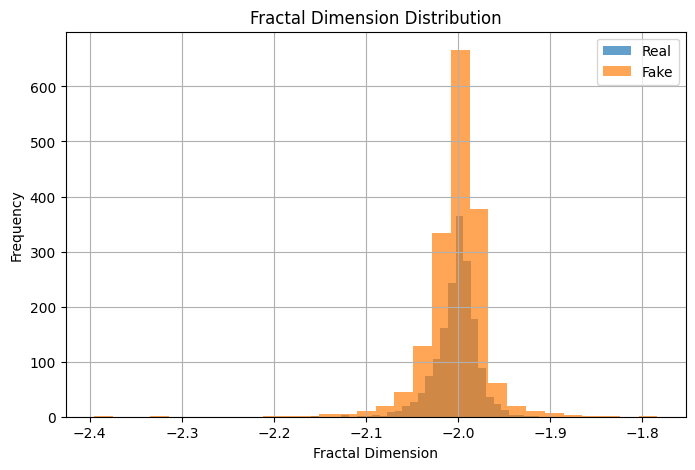

In [ ]:
fd_real = np.load(fd_real_path)
fd_fake = np.load(fd_fake_path)

plt.figure(figsize=(8, 5))
plt.hist(fd_real, bins=30, alpha=0.7, label="Real")
plt.hist(fd_fake, bins=30, alpha=0.7, label="Fake")
plt.title("Fractal Dimension Distribution")
plt.xlabel("Fractal Dimension")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def texture_complexity(R, D=16):
    R = np.abs(R)
    h, w = R.shape
    blocks = [R[i:i+D, j:j+D] for i in range(0, h-D+1, D) for j in range(0, w-D+1, D)]
    TCs = []
    for block in blocks:
        t = 1 - np.sum((2**(-block)) / (block + 1e-5)) / (D * D)
        # Clamp t value to avoid log(0) or negative
        t = np.clip(t, 1e-5, 1 - 1e-5)
        tc = np.log(t / (1 - t)) + 4
        TCs.append(tc)
    return np.array(TCs)


In [ ]:
tc_real_path = '/content/drive/MyDrive/deepfake/features/tc_real.npy'
tc_fake_path = '/content/drive/MyDrive/deepfake/features/tc_fake.npy'

def compute_tc_features(folder):
    features = []
    for file in tqdm(os.listdir(folder)):
        if file.endswith('.npy'):
            res = np.load(os.path.join(folder, file))
            tc = texture_complexity(res)
            features.append(tc.mean())  # Use mean-pooled TC
    return np.array(features)

tc_real = compute_tc_features(laplacian_real_path)
tc_fake = compute_tc_features(laplacian_fake_path)

np.save(tc_real_path, tc_real)
np.save(tc_fake_path, tc_fake)


100%|██████████| 1700/1700 [01:19<00:00, 21.47it/s]


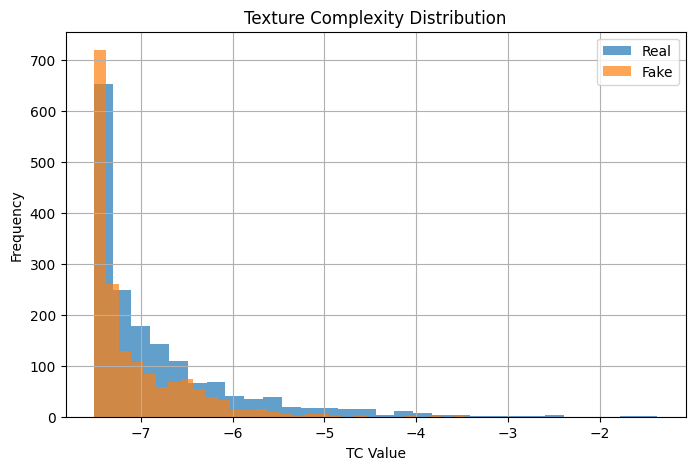

In [ ]:
tc_real = np.load(tc_real_path)
tc_fake = np.load(tc_fake_path)

plt.figure(figsize=(8, 5))
plt.hist(tc_real, bins=30, alpha=0.7, label="Real")
plt.hist(tc_fake, bins=30, alpha=0.7, label="Fake")
plt.title("Texture Complexity Distribution")
plt.xlabel("TC Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
fd_real = np.load(fd_real_path).reshape(-1, 1)
fd_fake = np.load(fd_fake_path).reshape(-1, 1)

tc_real = np.load(tc_real_path).reshape(-1, 1)
tc_fake = np.load(tc_fake_path).reshape(-1, 1)

X_real = np.hstack((fd_real, tc_real))
X_fake = np.hstack((fd_fake, tc_fake))

X = np.vstack((X_real, X_fake))
y = np.array([0] * len(X_real) + [1] * len(X_fake))  # 0=real, 1=fake


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.22      0.33       358
           1       0.50      0.88      0.64       322

    accuracy                           0.53       680
   macro avg       0.59      0.55      0.49       680
weighted avg       0.59      0.53      0.48       680

ROC AUC Score: 0.6124822165932198


In [ ]:
def load_grayscale_features(folder, label, size=(256, 256)):
    data, labels = [], []
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, size)
            data.append(img.flatten())  # Flatten 2D -> 1D
            labels.append(label)
    return data, labels

gr_real, lbl_real = load_grayscale_features(preproc_real_path, 0)
gr_fake, lbl_fake = load_grayscale_features(preproc_fake_path, 1)

X_gray = np.array(gr_real + gr_fake)
y_gray = np.array(lbl_real + lbl_fake)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_gray_scaled = scaler.fit_transform(X_gray)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_gray_scaled, y_gray, test_size=0.2, random_state=42)

# Try multiple classifiers
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "RBF SVM": SVC(kernel='rbf', probability=True),
    "Linear SVM": SVC(kernel='linear', probability=True),
    "Logistic Regression": LogisticRegression()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



Random Forest Accuracy: 0.8603
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       358
           1       0.87      0.82      0.85       322

    accuracy                           0.86       680
   macro avg       0.86      0.86      0.86       680
weighted avg       0.86      0.86      0.86       680


RBF SVM Accuracy: 0.8515
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       358
           1       0.86      0.82      0.84       322

    accuracy                           0.85       680
   macro avg       0.85      0.85      0.85       680
weighted avg       0.85      0.85      0.85       680


Linear SVM Accuracy: 0.6382
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       358
           1       0.59      0.75      0.66       322

    accuracy                           0.64       680
   macro avg       0.65      0.64      0.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
